In [1]:
using LinearAlgebra, JuMP, CPLEX, Plots, Distributions, Printf, JLD2

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A_drto = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
# uncertainty in B matrix
# B_drto = [0.0625; 0; 0] # nominal
C_drto = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

Controller configuration

In [4]:
# Output prediction horizon
p = 30 #30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 1;

DRTO configuration

In [26]:
# Prediction horizon 30 | 50
pD = 50
# Input control horizon 
mD = 20
# DRTO sampling time
nDRTO = 5;
#number os scenarios
nScen = 3
#equiprobable scenarios
pScen = 1.0/nScen;
# uncertainty in B - each column represent a different realization
B_drto_s = [0.05 0.0625 0.07; 0 0 0; 0 0 0];

Setting parameters for matrices for DRTO (Open and Closed-loop)

In [27]:
# setting initial values
x0 = [0.0;0.0;0.0]
y0 = C_drto'*[0.0;0.0;0.0]
u0 = 0.0;

# setting bounds 
ΔUMax = 0.3
uMax = 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0
yspMax = 1.5
yspMin = 0.0;

# Building MPC model

In [28]:
A = A_drto
B = [0.0625; 0; 0] # using nominal model 
C = C_drto;

## Adding disturbance model

The closed-loop system may never reach the desired controlled variable target if an unmeasured, constant disturbance
enters the process or if model error is present. This problem can be solved by incorporating a constant output disturbance
into the process model: 

$
\begin{vmatrix}
x(k + 1)\\
d(k + 1)
\end{vmatrix}
= 
\begin{vmatrix}
A & 0_{nx,ny}\\
0_{ny,nx} & I_{ny}\\
\end{vmatrix} \ x(k)
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
+
\begin{vmatrix}
B\\
0_{ny,nu}\end{vmatrix} 
u(k)
$

$
y(k)
= 
\begin{vmatrix}
C & G_p
\end{vmatrix} 
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
$

in which $d \in \mathcal{R}^{ny}$ is the number of augmented output disturbance states, and $G_p$ determines the effect of these states on the output. In the standard industrial model predictive control implementation, $G_p=I$ and the output
disturbance is estimated as $d_k = y_k - C x_k$.

In [29]:
Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
Bd = [B; 0]
Cd = [C; 1];

## Building matrices for MPC


Given the following discrete state-space model:

$ x(k+1) = A \ x(k) + b \ u(k) $ <br>
$ y(k) = C \ x(k)$ <br>

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as:
$ y(k + 1|k) = C \ x(k + 1|k) = CA \ x(k) + CB \ u(k|k)$ <br>
$ y(k + 2|k) = CA^2 \ x(k) + CAB \ u(k|k) + CB \ u(k+1|k)$ <br>
$ y(k + 3|k) = CA^3 \ x(k) + CA^2B \ u(k|k) + CAB \ u(k+1|k) + CB \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = CA^j \ x(k) + CA^{j-1}B \ u(k|k) + CA^{j-2}B \ u(k+1|k) + \cdots + CB \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = CA^{m+1} \ x(k) + CA^{m}B \ u(k|k) + CA^{m-1}B \ u(k+1|k) + \cdots + [CAB + CB] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = CA^{m+2} \ x(k) + CA^{m+1}B \ u(k|k) + CA^{m}B \ u(k+1|k) + \cdots + [CA^2B + CAB + CB] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = CA^{p} \ x(k) + CA^{p-1}B \ u(k|k) + CA^{p-2}B \ u(k+1|k) + \cdots + [CA^{p-m}B + CA^{p-m-1}B + \cdots + CB] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
CA\\
CA^{2}\\
\vdots \\
CA^{m} \\
CA^{m+1}\\ 
\vdots \\
CA^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
CB        & 0         & \cdots & 0\\
CAB       & CB        & \cdots & 0\\
\vdots    & \vdots    & \cdots & \vdots\\
CA^{m-1}B & CA^{m-2}B & \cdots & CB\\
CA^{m}B   & CA^{m-1}B & \cdots & C\tilde{A}_1B\\ 
\vdots    & \vdots    & \cdots & \vdots\\
CA^{p-1}B & CA^{p-2}B & \cdots & C\tilde{A}_{p-m}B
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_1 = A + I, \quad \tilde{A}_2 = A^2 + A + I, \quad \tilde{A}_{p-m} = A^{p-m} + A^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

In [30]:
Psi = Cd'*Ad
for ii in 2:p
    Psi = [Psi;  Cd'*Ad^ii]
end

# Computing Dynamic Matirx
a = [Cd'*Ad^(ii - 1)*Bd for ii in 1:p];
DynM = a

for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = Cd'*Bd

Ai = I(nx+1) # adding disturbance to the states
for ii = 1:(p - m)
    Ai = Ai + Ad^ii
    b = [b;Cd'*Ai*Bd]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

In [31]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [32]:
# Matrix H
H = Theta'*Qbar*Theta + IM'*Rbar*IM;

## Unconstrained MPC solution
the FOC of the unconstrained MPC problem is:

$$ \dfrac{\partial J_k}{\partial u_k}\bigg|_{u_k^\star} = 2 \ u_k^{\star,T} \ H + 2c_f^T = 0 $$ 
 
Hence: 

$$ \ u_k^{\star,T} \ H + c_f^T = 0 $$ 
$$ \ u_k^{\star,T} \ H = - c_f^T $$ 

Transposing both sides ($H$ is symmetric, $H^T = H$):

$$ H \ u_k^{\star} = - c_f $$ 

# Building function to solve CL-DRTO using MSS framework

$ \min_{\boldsymbol{y}^{SP}} \quad \Phi^{ECO}(\boldsymbol{x},\boldsymbol{y},\boldsymbol{u}) $ <br>

subjected to: ($k$ represents time and $s$ scenarios) <br>

For each scenario ($s = 1,\ldots,n^{scen}$) <br>
>    System dynamics <br>
>    $\boldsymbol{x}_{k + 1,s} = A\boldsymbol{x}_{k,s} + B_s\boldsymbol{u}_{k,s} $ <br>
>    $\boldsymbol{y}_{k,s} = C\boldsymbol{x}_{k,s}$

>    CL-DRTO control horizon: constraints fixing inputs after horizon ends <br>
>    $\boldsymbol{u}_{k,s} - \boldsymbol{u}_{k - 1,s} = 0, \quad k = m^{DRTO} + 1,\ldots,p^{DRTO}$

>    $\Delta u$ constraints (N.B.: $\boldsymbol{u}_{0}$ comes from the plant and it is the same for all scenarios) <br>
>    $-\Delta \boldsymbol{u}_{max} \leq \boldsymbol{u}_{k,s} - \boldsymbol{u}_{k-1,s} \leq \Delta \boldsymbol{u}_{max}, \quad k = 1,\ldots,m^{DRTO}$

>    Product quality target band <br>
>    $\boldsymbol{y}_{k,s} + \boldsymbol{\delta}^p_{k,s} \geq \boldsymbol{y}_{target,lb}$ <br>
>    $\boldsymbol{y}_{k,s} - \boldsymbol{\delta}^m_{k,s} \leq \boldsymbol{y}_{target,ub}$

>    Unconstrained MPC <br>
>    $H \ \boldsymbol{U}_{k,s} - c_f = 0$<br>
>    $\text{where} \quad c_f = f(\boldsymbol{x}_{k,s},\boldsymbol{u}_{k-1,s},\boldsymbol{Y}^{SP}_{k,s})$ <br>
>    $ \quad \quad \quad \boldsymbol{U}_{k,s} = [\boldsymbol{u}^{1}_{k,s},\boldsymbol{u}^{2}_{k,s},\ldots,\boldsymbol{u}^{m}_{k,s}]$<br>
>    $\quad \quad \quad \boldsymbol{Y}^{SP}_{k,s} = [\boldsymbol{y}^{SP,1}_{k,s},\boldsymbol{y}^{SP,2}_{k,s},\ldots,\boldsymbol{y}^{SP,p}_{k,s}]$ <br>

Non-antecipativity constraints <br>
$\boldsymbol{y}^{SP}_{k,s} = \boldsymbol{y}^{SP}_{k,S}, \quad k = 1,\ldots,\Delta t_{DRTO} \ \quad s = 1,\ldots,S - 1,S + 1,\ldots,n^{scen}$

Variable bounds <br>
$\forall k, \forall s \quad \boldsymbol{x}_{k,s} \in \mathcal{X}, \ \boldsymbol{u}_{k,s} \in \mathcal{U}, \ \boldsymbol{y}_{k,s} \in \mathcal{Y}, \ \boldsymbol{y}^{SP}_{k,s} \in \mathcal{Y}^{SP}$



## Connection between DRTO and MPC layers (inside CLDRTO formulation)

for one scenario:

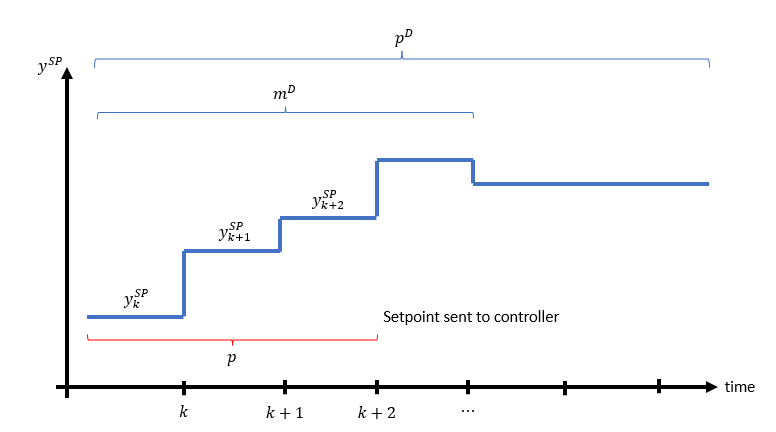

## Nonantecipativity constraints

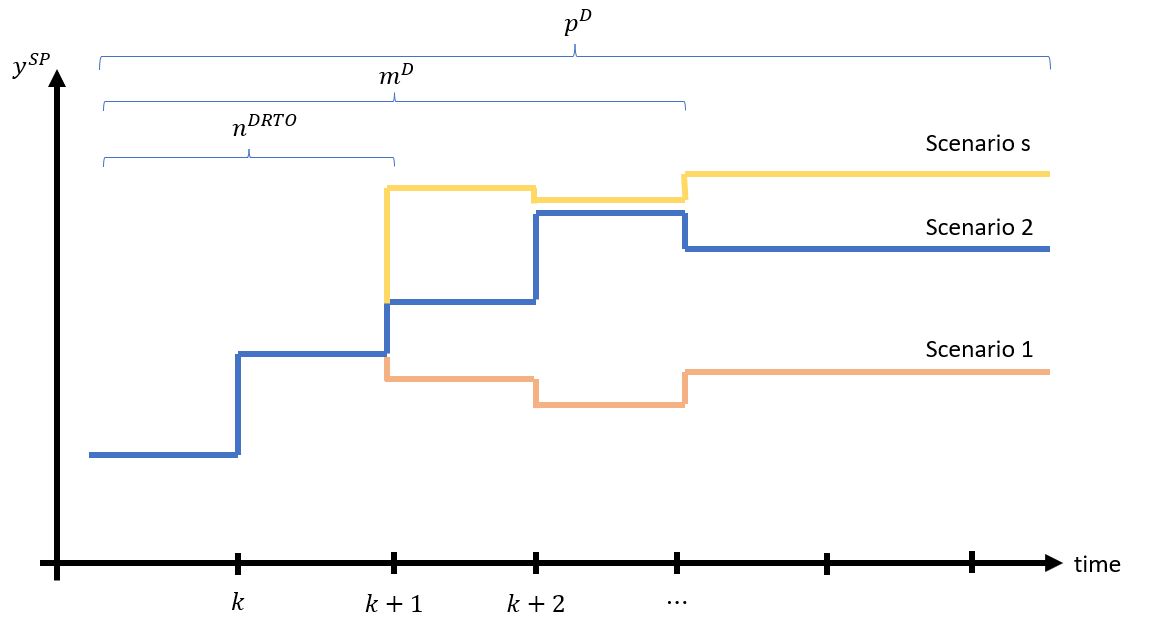

## Target zone for y

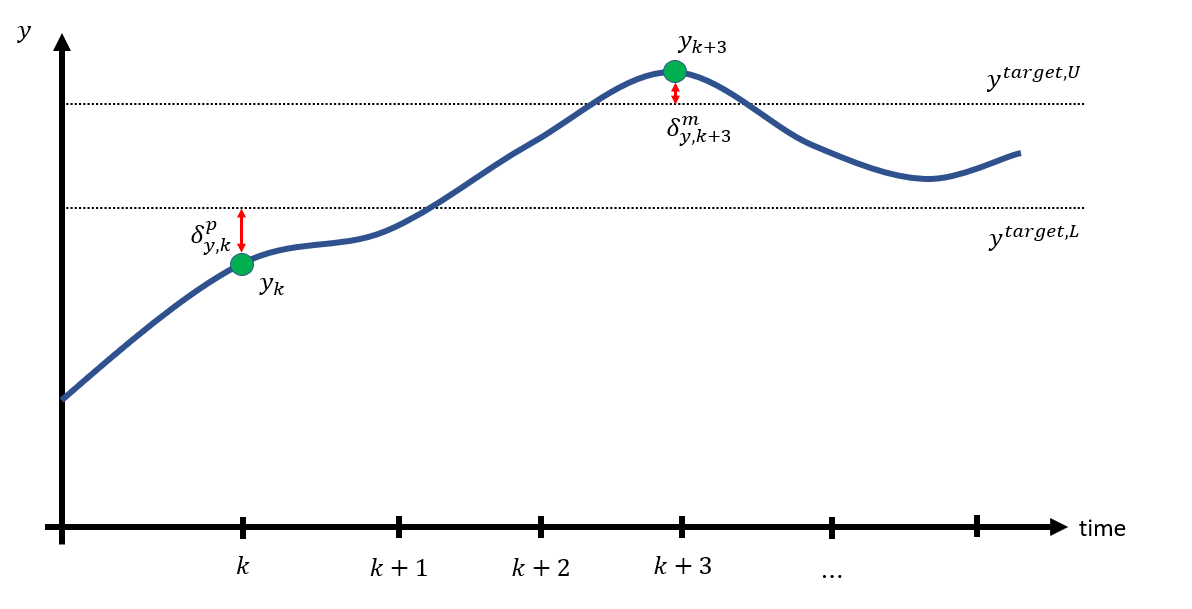

# Solving CL-DRTO Multiscenario Problem (monolithic)

In [67]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit)

    # Define our model
    model_ms = Model(CPLEX.Optimizer)
    #set_optimizer_attribute(model_ms, "CPXPARAM_ScreenOutput"=false)
    # set_optimizer_attribute(m, "warm_start_init_point", "yes")

    # Set up variables
    # inputs computed by MPCs
    @variable(model_ms, uMin <= u[1:pD,1:m,1:nScen] <= uMax)
    # initial states used by MPC for computing the optimal trajectory
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, yMin <= yDRTO[1:pD,1:nScen] <= yMax)
    @variable(model_ms, yMin <= yMPC[1:pD,1:nScen] <= yMax)
    @variable(model_ms, yspMin <= ysp[1:pD,1:nScen] <= yspMax)
    # model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    # slacks for controlling setpoint into a zone
    @variable(model_ms, delta_y_p[1:pD,1:nScen] >= 0)
    @variable(model_ms, delta_y_m[1:pD,1:nScen] >= 0)

    # Set up objective function
    @objective(model_ms, Min, pScen*sum(u[kk,1,ss] + 1e5*(delta_y_p[kk,ss]^2 + delta_y_m[kk,ss]^2) 
            for kk in 1:pD, ss in 1:nScen))

    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== A_drto*xInit + B_drto_s[:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== A_drto*xDRTO[kk,:,ss] + B_drto_s[:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == C_drto'*xDRTO[kk,:,ss])
    
    # Model Dynamic for Controller
    @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== A*xInit + B*uInit)
    @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== A*xMPC[kk,:,ss] + B*u[kk,1,ss])
    @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == C'*xMPC[kk,:,ss])

    #  Model deviation
    @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

    # Unconstrained MPC solution
    @expression(model_ms, cfT_1[ss=1:nScen], (Psi*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (Psi*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*Qbar*Theta - u[kk-1,1,ss]'*Ibar'*Rbar*IM)

    @constraint(model_ms, MPC_sol_1[ss=1:nScen], H*u[1,:,ss] + cfT_1[ss]' .== 0)
    @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], H*u[kk,:,ss] + cfT[kk,ss]' .== 0)
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])

    # Δu constraints
    @constraint(model_ms, ΔU_max_0[ss=1:nScen], -ΔUMax <= u[1,1,ss] - uInit <= ΔUMax)
    @constraint(model_ms, ΔU[kk=2:mD,ss=1:nScen], -ΔUMax <= u[kk,1,ss] - u[kk - 1,1,ss] <= ΔUMax)

    # ysp in target
    @constraint(model_ms, target_plus[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] + delta_y_p[kk,ss] >= 0.95)
    @constraint(model_ms, target_minus[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_y_m[kk,ss] <= 1.05)

    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    # @show model_ms
    
    optimize!(model_ms)
    flag = termination_status(model_ms)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(model_ms)
    uArray = value.(u)
    yArray = value.(yDRTO)
    yspArray = value.(ysp)
    dpArray = value.(delta_y_p)
    dmArray = value.(delta_y_m)
    
    # all_con = all_constraints(model_ms, AffExpr, MOI.EqualTo{Float64})
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'y' => yArray, 'p' => dpArray, 'm' => dmArray, 'd'=>yspArray)
end;

Solve Model

In [68]:
# Solve the model
solDict = MS_CLDRTO(x0,u0);

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 156 rows and 342 columns.
Aggregator did 772 substitutions.
Reduced QP has 1062 rows, 1196 columns, and 9828 nonzeros.
Reduced QP objective Q matrix has 285 nonzeros.
Presolve time = 0.00 sec. (2.29 ticks)
Parallel mode: using up to 16 threads for barrier.

***NOTE: Found 3 dense columns.

Number of nonzeros in lower triangle of A*A' = 12807
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (1.08 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 1065
  Integer space required    = 3045
  Total non-zeros in factor = 22862
  Total FP ops to factor    = 856340
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.5707655e+06  -1.0076559e+07  2.31e+03  6.32e+02  1.90e+07
   1   2.4866277e+06  -2.5100025e+06  1.08e+0

In [69]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Extracting solution for plotting
yTraj_m_cl = Array{Float64}(undef,pD,nScen)
uTraj_m_cl = Matrix{Float64}(undef,pD,nScen) 
yspTraj_m_cl = Matrix{Float64}(undef,pD,nScen) 

for i in 1:pD
    for s in 1:nScen
        yTraj_m_cl[i,s] = solDict['y'][i,s]
        yspTraj_m_cl[i,s] = solDict['d'][i,s]
        uTraj_m_cl[i,s] = solDict['u'][i,1,s]
    end
end;

#display(solDict['d'][1,1])
#display(solDict['d'][1,2])
#display(solDict['d'][1,3])

# Solving CL-DRTO Multiscenario Problem (decomposed)

In [70]:
# Creating function to print the results of the iterations
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    # lpad: Stringify k and make it n characters (in textwidth) long.  
    # If k is already n characters long, an equal string is returned. Pad with spaces by default.
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end

print_iteration (generic function with 1 method)

## Modeling Subproblem

In [71]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,scen)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - non-antecipativity constraints (first nDRTO setpoints must be equal among scenarios)
    # scen - which scenario the subproblem represents

    # Define subproblem model
    sub = Model(CPLEX.Optimizer)
    set_silent(sub) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(sub, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(sub, yMin <= y[1:pD] <= yMax)
    
    # MPC states
    @variable(sub, xMPC[1:pD, 1:nx])
    # MPC model outputs
    @variable(sub, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(sub, uMin <= u[1:pD,1:m] <= uMax)
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, yMin <= yMPC[1:pD] <= yMax)
    
    # model deviation
    @variable(sub, de[1:pD])
    
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_y_p[1:pD] >= 0)
    @variable(sub, delta_y_m[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(sub, Min, pScen*sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, x[1,:] .== A_drto*xInit + B_drto_s[:,scen]*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A_drto*x[kk,:] + B_drto_s[:,scen]*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], y[kk] == C_drto'*x[kk,:])

    # MPC model (linear)
    @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== A*xInit + B*uInit)
    @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== A*xMPC[kk,:] + B*u[kk,1])
    @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == C'*xMPC[kk,:])
    
    #  MPC model deviation (disturance)
    @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == y[kk] - yMPC[kk])

    # Unconstrained MPC solution
    @expression(sub, cfT_1, (Psi*[xMPC[1,:];de[1]] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(sub, cfT[kk=2:mD], (Psi*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)

    @constraint(sub, MPC_sol_1, H*u[1,:] + cfT_1' .== 0)
    @constraint(sub, MPC_sol[kk=2:mD], H*u[kk,:] + cfT[kk]' .== 0)
    
    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    @constraint(sub, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    @constraint(sub, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(sub, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(sub, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    # @show model_ms
    
    optimize!(sub)
    flag = termination_status(sub)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(sub)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    # lagrange multipliers associated with the nonantecipativity constraints
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

In [72]:
## Modeling the master problem  --> checking the problem use> print(master)

# Degine master problem model
master = Model(CPLEX.Optimizer)
set_silent(master)

####################
# Set up variables #
####################
@variable(master, yspMin <= ysp[1:nDRTO] <= yspMax, start = 0.5)

#lower bound on scenario objective function approximation 
alpha_down = 0.0;
@variable(master, α ≥ alpha_down)

#############################
# Set up objective function #
#############################
@objective(master, Min, α);

In [73]:
# solving problem with random initial guesses for the solution of the master problem 
# to ensure that the algorithm does not get stuck at initial solution 
for ii in 1:3
    # guess for initial first stage variables
    if ii == 1
        ysp_nonⁱ = [0.5, 0.5, 0.5, 0.5, 0.5]
    elseif ii == 2
        ysp_nonⁱ = [1.0, 1.0, 1.0, 1.0, 1.0]
    else
        ysp_nonⁱ = [1.2, 1.2, 1.2, 1.2, 1.2]
    end
        
    # print iteration information
    print_iteration(ii,ysp_nonⁱ[1],ysp_nonⁱ[2],ysp_nonⁱ[3],ysp_nonⁱ[4],ysp_nonⁱ[5])

    # sensitivity (for adding Benders' cut)
    lambda_N = [subp(x0,u0,ysp_nonⁱ,ss)['λ']' for ss in 1:nScen]  
    
    # objective function computed in ysp_nonⁱ
    ofⁱ = sum(subp(x0,u0,ysp_nonⁱ,ss)['o'] for ss in 1:nScen)
    # display(ub)
    
    # adding Benders' cut to the master problem
    benderscut = @constraint(master, α ≥ ofⁱ + sum(sum(lambda_N[ss][jj] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
    @info "Adding this bender cut $(benderscut)"
end



        1   5.0000e-01   5.0000e-01   5.0000e-01   5.0000e-01   5.0000e-01
        2   1.0000e+00   1.0000e+00   1.0000e+00   1.0000e+00   1.0000e+00

[ Info: Adding this bender cut -687.4742281067934 ysp[1] - 4258.835814639329 ysp[2] - 10104.262397538145 ysp[3] - 16002.968500533887 ysp[4] - 20475.569808634154 ysp[5] + α >= 1.0643546516472283e6



        3   1.2000e+00   1.2000e+00   1.2000e+00   1.2000e+00   1.2000e+00


[ Info: Adding this bender cut -811.3809885217565 ysp[1] - 5046.815083528573 ysp[2] - 12073.93878767522 ysp[3] - 19348.44018270782 ysp[4] - 25139.58283279887 ysp[5] + α >= 1.0563798238620865e6
[ Info: Adding this bender cut -893.3387963790875 ysp[1] - 5569.03229693626 ysp[2] - 13384.325192452383 ysp[3] - 21585.735931709743 ysp[4] - 28278.922812992976 ysp[5] + α >= 1.0483383874530559e6


In [74]:
# preparing plot and table(header) for checking iteration evolution
println("k  ysp[1]  ysp[2]  ysp[3]  ysp[4]  ysp[5]   lowerbound  upperbound  gap")
p3 = plot(legend=false, xlabel="iteration", ylabel="OF value")

# solving problem with benders' decomposition 
for ii in 1:20
    # solve master problem (with Benders' cut)
    optimize!(master)
    
    # Master problem solution: lower bound of the original problem
    lb = objective_value(master)
    
    # extracting solution
    ysp_nonⁱ = value.(ysp)
    
    # solve subproblems to find the upper bound of the original problem solution 
    ub = sum(subp(x0,u0,ysp_nonⁱ,ss)['o'] for ss in 1:nScen)
    
    # compute optimality gap
    gap = abs(ub - lb)/abs(ub)
    
    # print iteration information
    print_iteration(ii,ysp_nonⁱ[1],ysp_nonⁱ[2],ysp_nonⁱ[3],ysp_nonⁱ[4],ysp_nonⁱ[5],lb,ub,gap)
    
    # add information to the plot
    plot!([ii],[lb], marker=:circle,  markercolor = :green)
    plot!([ii],[ub], marker=:square, markercolor = :red)
    
    # check if optimality gap is small enough
    if gap < 1e-5 
        println(" **** solution found ********")
        global yspSol = ysp_nonⁱ
        break
    end
    
    # IF NOT 
    # sensitivity (for adding Benders' cut)
    lambda_N = [subp(x0,u0,ysp_nonⁱ,ss)['λ']' for ss in 1:nScen]  
    #display(lambda_N[1][2])
    #display(lambda_N[2][2])
    #display(lambda_N[3][2])
    #display(size(lambda_N))
    
    # adding Benders' cut to the master problem
    benderscut = @constraint(master, α ≥ ub + sum(sum(lambda_N[ss][jj] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
    #@info "Adding this bender cut $(benderscut)"
end

k  ysp[1]  ysp[2]  ysp[3]  ysp[4]  ysp[5]   lowerbound  upperbound  gap
        1   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   1.0644e+06   1.0670e+06   2.4697e-03
        2   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   1.0670e+06   1.0670e+06   0.0000e+00
 **** solution found ********


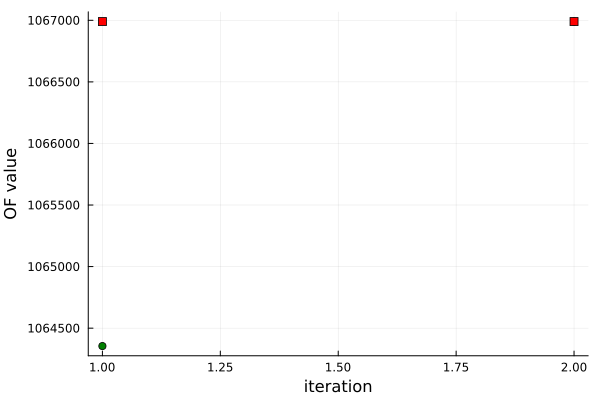

In [75]:
display(p3)

In [76]:
# Get values for plotting
uTraj_d_cl = Matrix{Float64}(undef,pD,nScen) 
yTraj_d_cl = Matrix{Float64}(undef,pD,nScen) 
yspTraj_d_cl = Matrix{Float64}(undef,pD,nScen) 

for ss in 1:nScen
    yTraj_d_cl[:,ss] = subp(x0,u0,yspSol,ss)['y']
    yspTraj_d_cl[:,ss] = subp(x0,u0,yspSol,ss)['s']
    uTraj_d_cl[:,ss] = subp(x0,u0,yspSol,ss)['u'][:,1]
end;

In [77]:
# loading open-loop data
#yTraj_d_ol = JLD2.load("OL_decomp.jld2","yTraj_d_ol")
#uTraj_d_ol = JLD2.load("OL_decomp.jld2","uTraj_d_ol");

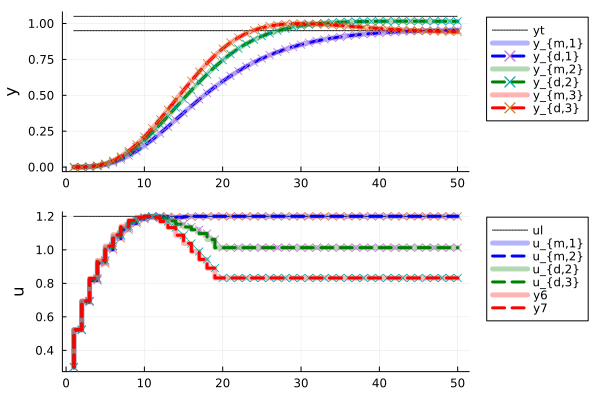

In [78]:
gr()

# limits
p4 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p4 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)

# scenario 1
p4 = plot!(ts,yTraj_m_cl[:,1],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :blue)
p4 = plot!(ts,yTraj_d_cl[:,1],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :blue)

# scenario 1
p4 = plot!(ts,yTraj_m_cl[:,2],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :green,legend=false)
p4 = plot!(ts,yTraj_d_cl[:,2],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :green,legend=false)

# scenario 1
p4 = plot!(ts,yTraj_m_cl[:,3],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :red,legend=false)
p4 = plot!(ts,yTraj_d_cl[:,3],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :red,legend=false)
    
p4.series_list[1][:label] = "yt"
p4.series_list[2][:label] = ""
p4.series_list[3][:label] = "y_{m,1}"
p4.series_list[4][:label] = "y_{d,1}"
p4.series_list[5][:label] = "y_{m,2}"
p4.series_list[6][:label] = "y_{d,2}"
p4.series_list[7][:label] = "y_{m,3}"
p4.series_list[8][:label] = "y_{d,3}"

# limtes
p5 = plot(ts,1.2*ones(length(ts)),linestyle = :dot,linecolor = :black)

# scenario 1
p5 = plot!(ts,uTraj_m_cl[:,1],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :blue)
p5 = plot!(ts,uTraj_d_cl[:,1],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :blue)

# scenario 2
p5 = plot!(ts,uTraj_m_cl[:,2],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :green,legend=false)
p5 = plot!(ts,uTraj_d_cl[:,2],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :green,legend=false)

# scenario 3
p5 = plot!(ts,uTraj_m_cl[:,3],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :red,legend=false)
p5 = plot!(ts,uTraj_d_cl[:,3],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :red,legend=false)

p5.series_list[1][:label] = "ul"
p5.series_list[2][:label] = "u_{m,1}"
p5.series_list[3][:label] = "u_{d,1}"
p5.series_list[4][:label] = "u_{m,2}"
p5.series_list[5][:label] = "u_{d,2}"
p5.series_list[6][:label] = "u_{m,3}"
p5.series_list[7][:label] = "u_{d,3}"

g2 = plot(p4,p5,layout=(2,1),legend=:outertopright)
display(g2)

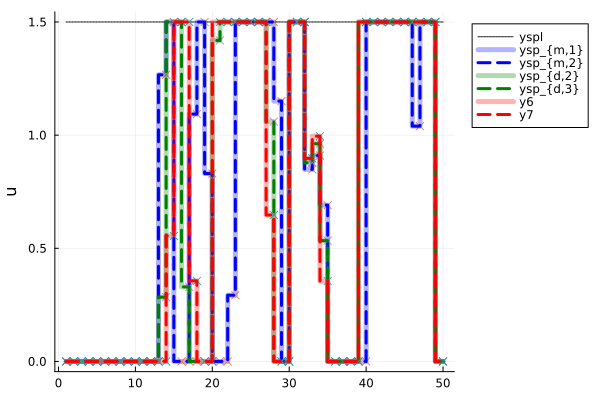

In [79]:
gr()

p6 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=:outertopright)

# scenario 1
p6 = plot!(ts,yspTraj_m_cl[:,1],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :blue)
p6 = plot!(ts,yspTraj_d_cl[:,1],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :blue)

# scenario 2
p6 = plot!(ts,yspTraj_m_cl[:,2],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :green)
p6 = plot!(ts,yspTraj_d_cl[:,2],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :green)

# scenario 3
p6 = plot!(ts,yspTraj_m_cl[:,3],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :red)
p6 = plot!(ts,yspTraj_d_cl[:,3],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :red)

p6.series_list[1][:label] = "yspl"
p6.series_list[2][:label] = "ysp_{m,1}"
p6.series_list[3][:label] = "ysp_{d,1}"
p6.series_list[4][:label] = "ysp_{m,2}"
p6.series_list[5][:label] = "ysp_{d,2}"
p6.series_list[6][:label] = "ysp_{m,3}"
p6.series_list[7][:label] = "ysp_{d,3}"

display(p6)